<a href="https://colab.research.google.com/github/pepper999/abalone-age/blob/main/%EC%A0%84%EB%B3%B5%EB%82%98%EC%9D%B4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#사전작업

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm
import os
import warnings
from numpy import mean
from numpy import std
from numpy import asarray
from sklearn.preprocessing import PowerTransformer
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.inspection import PartialDependenceDisplay
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/age_data/train.csv')
train.drop('id', inplace = True, axis=1)
test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/age_data/test.csv")
test.drop('id', inplace = True, axis=1)
sample_submission = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/age_data/sample_submission.csv")

# EDA

In [ ]:
# 데이터의 수
print(f"train : {train.shape}")
print(f"test : {test.shape}")

train : (1253, 9)
test : (2924, 8)


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860 entries, 0 to 1859
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Gender          1860 non-null   int64  
 1   Lenght          1860 non-null   float64
 2   Diameter        1860 non-null   float64
 3   Height          1860 non-null   float64
 4   Whole Weight    1860 non-null   float64
 5   Shucked Weight  1860 non-null   float64
 6   Viscra Weight   1860 non-null   float64
 7   Shell Weight    1860 non-null   float64
 8   Target          1860 non-null   int64  
dtypes: float64(7), int64(2)
memory usage: 130.9 KB


In [ ]:
train.describe()

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
count,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000,1253.000000
mean,0.522869,0.406963,0.139545,0.831199,0.358818,0.181006,0.240077,9.912211
std,0.120231,0.099771,0.039033,0.500491,0.224612,0.111936,0.142574,3.214676
min,0.110000,0.090000,0.030000,0.008000,0.002500,0.002000,0.003000,3.000000
25%,0.445000,0.345000,0.115000,0.440500,0.182500,0.092500,0.130000,8.000000
50%,0.535000,0.420000,0.140000,0.777500,0.326000,0.168000,0.230000,10.000000
75%,0.615000,0.480000,0.165000,1.160000,0.505500,0.256500,0.330000,11.000000
max,0.780000,0.630000,0.250000,2.779500,1.488000,0.760000,1.005000,29.000000


Index(['Lenght', 'Diameter', 'Height', 'Whole Weight', 'Shucked Weight',
       'Viscra Weight', 'Shell Weight', 'Target'],
      dtype='object')


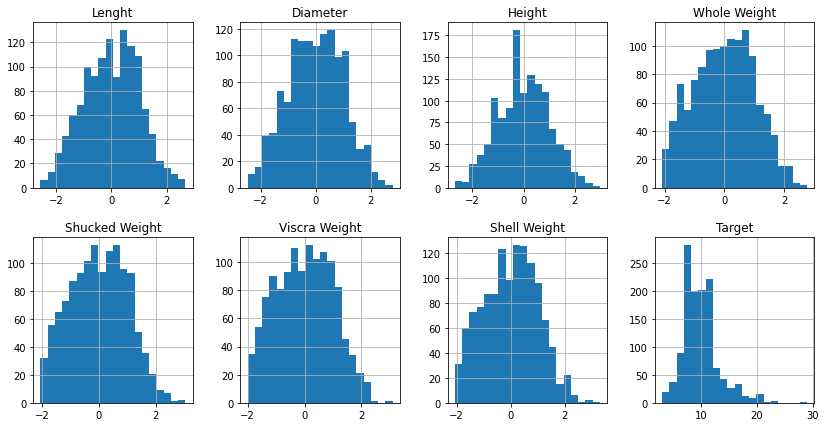

In [ ]:
plot_cols_list = train.columns[1:]
print(plot_cols_list)

train[plot_cols_list].hist(figsize = (14,7),grid = True, layout = (2,4), bins = 20)
plt.show()

,Lenght,Diameter,Height,Whole Weight,Shucked Weight,Viscra Weight,Shell Weight,Target
Lenght,1.000000,0.987293,0.901911,0.926321,0.896337,0.903732,0.895664,0.543789
Diameter,0.987293,1.000000,0.908348,0.927205,0.891183,0.901029,0.904546,0.567933
Height,0.901911,0.908348,1.000000,0.895409,0.837456,0.868192,0.902180,0.604654
Whole Weight,0.926321,0.927205,0.895409,1.000000,0.968007,0.966942,0.951652,0.538404
Shucked Weight,0.896337,0.891183,0.837456,0.968007,1.000000,0.932138,0.870453,0.420126
Viscra Weight,0.903732,0.901029,0.868192,0.966942,0.932138,1.000000,0.905061,0.497283
Shell Weight,0.895664,0.904546,0.902180,0.951652,0.870453,0.905061,1.000000,0.625819
Target,0.543789,0.567933,0.604654,0.538404,0.420126,0.497283,0.625819,1.000000


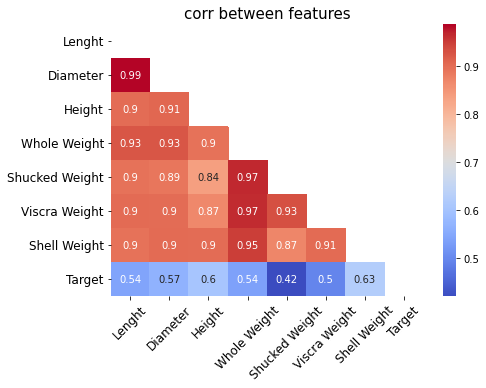

In [ ]:
# 상관행렬 히트맵
def corr_heat(df):
    plt.figure(figsize=(7,5))

    corr_df = df.corr()
    display(corr_df)

    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = 1
    heat_map = sns.heatmap(corr_df, annot=True, mask = mask, cmap='coolwarm')
    heat_map.set_xticklabels(heat_map.get_xticklabels(), fontsize=12, rotation=45)
    heat_map.set_yticklabels(heat_map.get_yticklabels(), fontsize=12)
    plt.title('corr between features', fontsize=15)
    plt.show()
    
corr_heat(train[plot_cols_list])

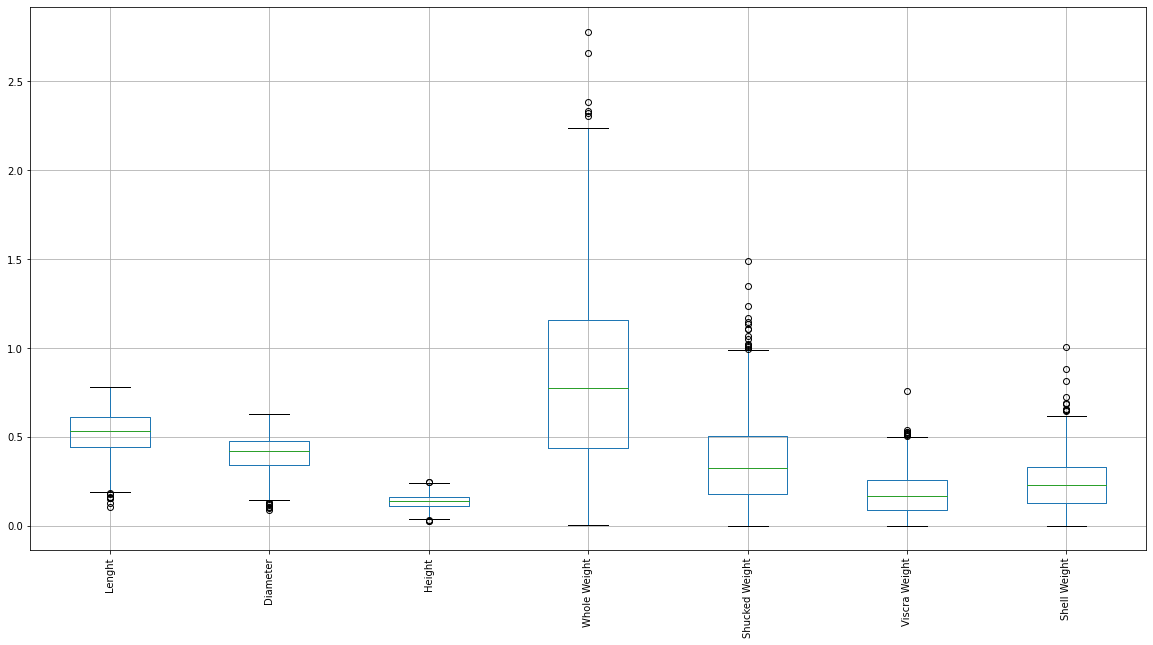

In [ ]:
# box plot
train[plot_cols_list[:-1]].boxplot(rot = 90, figsize=(20,10))

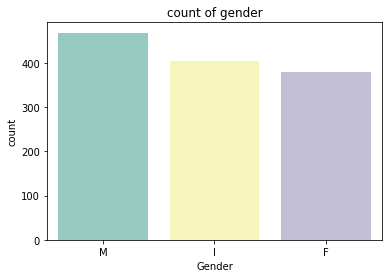

In [ ]:
sns.countplot(x = 'Gender', data = train, palette = "Set3")
plt.title('count of gender')
plt.show()

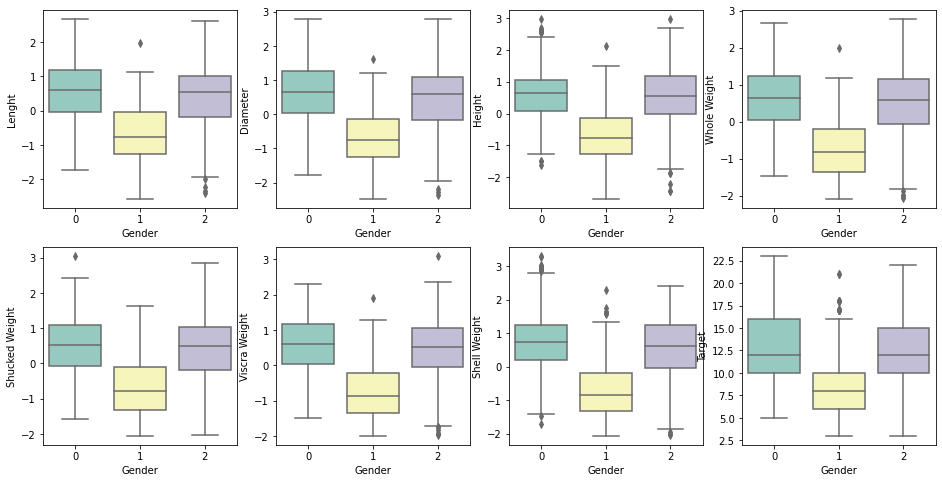

In [ ]:
fig = plt.figure(figsize=(16,8))

for i,col in enumerate(plot_cols_list):
    fig.add_subplot(2,4,i+1)
    sns.boxplot(x="Gender", y=col, data=train, palette="Set3")
    # plt.title(f'{col}')

In [ ]:
print(train)

     Gender  Lenght  Diameter  Height  Whole Weight  Shucked Weight  \
0         M   0.605     0.470   0.115        1.1140          0.3925   
1         I   0.430     0.315   0.095        0.3780          0.1750   
2         I   0.580     0.490   0.195        1.3165          0.5305   
3         M   0.535     0.405   0.175        1.2705          0.5480   
4         I   0.310     0.235   0.090        0.1270          0.0480   
...     ...     ...       ...     ...           ...             ...   
1248      I   0.190     0.145   0.040        0.0380          0.0165   
1249      I   0.395     0.310   0.085        0.3170          0.1530   
1250      F   0.525     0.410   0.115        0.7745          0.4160   
1251      F   0.445     0.335   0.110        0.4355          0.2025   
1252      F   0.750     0.550   0.195        1.8325          0.8300   

      Viscra Weight  Shell Weight  Target  
0            0.2910        0.3100      15  
1            0.0800        0.1045       8  
2            0.

# 전처리

## Power Transformation

In [ ]:
PT = PowerTransformer(method = 'yeo-johnson', standardize = True)
train_trans = PT.fit_transform(train.drop('Gender', axis = 1))
train['Lenght'] = train_trans[:,0]
train['Diameter'] = train_trans[:,1]
train['Height'] = train_trans[:,2]
train['Whole Weight'] = train_trans[:,3]
train['Shucked Weight'] = train_trans[:,4]
train['Viscra Weight'] = train_trans[:,5]
train['Shell Weight'] = train_trans[:,6]

In [ ]:
test_trans = PT.fit_transform(test.drop('Gender', axis = 1))
test['Lenght'] = test_trans[:,0]
test['Diameter'] = test_trans[:,1]
test['Height'] = test_trans[:,2]
test['Whole Weight'] = test_trans[:,3]
test['Shucked Weight'] = test_trans[:,4]
test['Viscra Weight'] = test_trans[:,5]
test['Shell Weight'] = test_trans[:,6]

##이상치 제거/기타 작업

In [6]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(train['Gender'])
gender_encoded_train = encoder.transform(train['Gender'])
gender_encoded_test = encoder.transform(test['Gender'])
train['Gender'] = gender_encoded_train
test['Gender'] = gender_encoded_test

In [7]:
# 전복의 나이 극단치(29)
train = train.drop(index = [762], axis = 0)

In [8]:
# 전복의 전체 무게 < 전복의 무게 + 껍질의 무게
train = train.drop(index = [47, 382, 435, 847, 1078], axis = 0)

In [9]:
# 전복의 무게 < 전복의 내장 무게
train = train.drop(index = [465], axis = 0)

In [10]:
foreign_body = train['Whole Weight'] - (train['Shucked Weight'] + train['Viscra Weight'] + train['Shell Weight'])
train['foreign body'] = foreign_body

train.loc[train['foreign body'] < 0 , 'foreign body'] = 0

foreign_body = test['Whole Weight'] - (test['Shucked Weight'] + test['Viscra Weight'] + test['Shell Weight'])
test['foreign body'] = foreign_body
test.loc[test['foreign body'] < 0 , 'foreign body'] = 0

In [11]:
water = train['Whole Weight'] - (train['Shell Weight']+train['Shucked Weight'])
train['Water'] = abs(water)

water = test['Whole Weight'] - (test['Shell Weight']+test['Shucked Weight'])
test['Water'] = abs(water)

In [12]:
train['Water']

0       0.4115
1       0.0985
2       0.3760
3       0.3855
4       0.0390
         ...  
1248    0.0065
1249    0.0705
1250    0.1785
1251    0.1135
1252    0.5625
Name: Water, Length: 1246, dtype: float64

In [13]:
train.reset_index(drop = True,inplace = True)

# Boosting 기법

##모델링(GBM)

In [14]:
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_regression
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [15]:
X = train.drop('Target', axis=1)
y = train['Target']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=722)
skf.split(X, X['Gender'])

pred_list = []
mae_list = []

for fold,(train_index, val_index) in enumerate(skf.split(X,  X['Gender'])):

    x_train, x_val, y_train, y_val = X.loc[train_index], X.loc[val_index], y.loc[train_index], y.loc[val_index]

    model = HistGradientBoostingRegressor()

    model.fit(x_train, y_train)
           

    pred = model.predict(x_val)
    result = mean_absolute_error(pred,y_val)
    mae_list.append(result)
    
    pred_test = model.predict(test)
    pred_list.append(pred_test)
    
        
print(f'mean mae {np.mean(mae_list):.4f}')

mean mae 1.6999


In [16]:
final_pred = np.mean(pred_list,axis=0)

##모델링(LGBM)

In [ ]:
X = train.drop('Target',axis = 1)
y = train['Target']

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error


skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=722)
skf.split(X, X['Gender'])

pred_list = []
mae_list = []

for fold,(train_index, val_index) in enumerate(skf.split(X,  X['Gender'])):

    print(f'***********{fold+1}th fold start***********')
    x_train, x_val, y_train, y_val = X.loc[train_index], X.loc[val_index], y.loc[train_index], y.loc[val_index]

    model = lightgbm.LGBMRegressor(boosting_type='gbdt',
        n_estimator= 80, random_state=722, learning_rate=0.05, categorical_feature=[0])

    model.fit(x_train, y_train,
            eval_set=(x_val,y_val),
            eval_metric='l1', verbose=False, early_stopping_rounds=100)

    pred = model.predict(x_val)
    result = mean_absolute_error(pred,y_val)
    mae_list.append(result)
    
    pred_test = model.predict(test)
    pred_list.append(pred_test)
    
    print(f'mae : {result:.4f}', end='\n\n')
    
print(f'mean mae {np.mean(mae_list):.4f}')

***********1th fold start***********
mae : 1.6301

***********2th fold start***********


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


mae : 1.6005

***********3th fold start***********
mae : 1.4422

***********4th fold start***********


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))
/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


mae : 1.5595

***********5th fold start***********
mae : 1.6040

mean mae 1.5672


/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


In [ ]:
final_pred = np.mean(pred_list,axis=0)

## 모델링(XGboost)

In [ ]:
from sklearn.datasets import make_regression
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

In [ ]:
X = train.drop('Target', axis=1)
y = train['Target']

skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=60)
skf.split(X, X['Gender'])

pred_list = []
mae_list = []

for fold,(train_index, val_index) in enumerate(skf.split(X,  X['Gender'])):

    x_train, x_val, y_train, y_val = X.loc[train_index], X.loc[val_index], y.loc[train_index], y.loc[val_index]

    print(f'***********{fold+1}th fold start***********')

    model = XGBRegressor(n_estimators = 60, learning_rate = .05,
                         objective='reg:squarederror')

    model.fit(x_train, y_train)
           

    pred = model.predict(x_val)
    result = mean_absolute_error(pred,y_val)
    mae_list.append(result)
    
    pred_test = model.predict(test)
    pred_list.append(pred_test)
    
    print(f'mae : {result:.4f}', end='\n\n')
        
print(f'mean mae {np.mean(mae_list):.4f}')

***********1th fold start***********
mae : 2.0637

***********2th fold start***********
mae : 2.0219

***********3th fold start***********
mae : 1.9038

***********4th fold start***********
mae : 2.3058

***********5th fold start***********
mae : 2.1015

***********6th fold start***********
mae : 2.0972

mean mae 2.0823


In [ ]:
final_pred = np.mean(pred_list,axis=0)

##모델링(MLP)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import HuberRegressor

In [ ]:
X = train.drop('Target', axis=1)
y = train['Target']

skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=60)
skf.split(X, X['Gender'])

pred_list = []
mae_list = []

for fold,(train_index, val_index) in enumerate(skf.split(X,  X['Gender'])):

    x_train, x_val, y_train, y_val = X.loc[train_index], X.loc[val_index], y.loc[train_index], y.loc[val_index]

    print(f'***********{fold+1}th fold start***********')

    model = MLPRegressor(random_state = 42, activation = 'tanh')

    model.fit(x_train, y_train)
           

    pred = model.predict(x_val)
    result = mean_absolute_error(pred,y_val)
    mae_list.append(result)
    
    pred_test = model.predict(test)
    pred_list.append(pred_test)
    
    print(f'mae : {result:.4f}', end='\n\n')
        
print(f'mean mae {np.mean(mae_list):.4f}')

***********1th fold start***********


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


mae : 2.0271

***********2th fold start***********


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


mae : 1.9728

***********3th fold start***********


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


mae : 1.8592

***********4th fold start***********


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


mae : 2.2006

***********5th fold start***********


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


mae : 2.1237

***********6th fold start***********
mae : 2.0841

mean mae 2.0446


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [ ]:
final_pred = np.mean(pred_list,axis=0)

##모델링(NGB)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import HuberRegressor
from sklearn.utils import shuffle
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from ngboost import NGBRegressor

In [ ]:
X = train.drop('Target', axis=1)
y = train['Target']

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=60)
skf.split(X, X['Gender'])

pred_list = []
mae_list = []

for fold,(train_index, val_index) in enumerate(skf.split(X,  X['Gender'])):

    x_train, x_val, y_train, y_val = X.loc[train_index], X.loc[val_index], y.loc[train_index], y.loc[val_index]

    print(f'***********{fold+1}th fold start***********')

    model = NGBRegressor(random_state = 42, verbose = 0)

    model.fit(x_train, y_train)
           

    pred = model.predict(x_val)
    result = mean_absolute_error(pred,y_val)
    mae_list.append(result)
    
    pred_test = model.predict(test)
    pred_list.append(pred_test)
    
    print(f'mae : {result:.4f}', end='\n\n')
        
print(f'mean mae {np.mean(mae_list):.4f}')

In [ ]:
final_pred = np.mean(pred_list,axis=0)

## 모델링(Catboost)

In [ ]:
from catboost import CatBoostRegressor

In [ ]:
X = train.drop('Target', axis=1)
y = train['Target']

skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=60)
skf.split(X, X['Gender'])

pred_list = []
mae_list = []

for fold,(train_index, val_index) in enumerate(skf.split(X,  X['Gender'])):

    x_train, x_val, y_train, y_val = X.loc[train_index], X.loc[val_index], y.loc[train_index], y.loc[val_index]

    print(f'***********{fold+1}th fold start***********')
    model = CatBoostRegressor(iterations=400,
                             learning_rate=0.03,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20)
    
    model.fit(x_train, y_train)
           

    pred = model.predict(x_val)
    result = mean_absolute_error(pred,y_val)
    mae_list.append(result)
    
    pred_test = model.predict(test)
    pred_list.append(pred_test)
    
    print(f'mae : {result:.4f}', end='\n\n')
        
print(f'mean mae {np.mean(mae_list):.4f}')

***********1th fold start***********
0:	learn: 3.1015092	total: 38.9ms	remaining: 15.5s
50:	learn: 2.2561187	total: 1.68s	remaining: 11.5s
100:	learn: 2.0104045	total: 3.2s	remaining: 9.47s
150:	learn: 1.8572786	total: 4.71s	remaining: 7.77s
200:	learn: 1.7539159	total: 6.21s	remaining: 6.14s
250:	learn: 1.6495348	total: 7.75s	remaining: 4.6s
300:	learn: 1.5635994	total: 9.31s	remaining: 3.06s
350:	learn: 1.4944320	total: 10.9s	remaining: 1.52s
399:	learn: 1.4220431	total: 11.7s	remaining: 0us
mae : 1.5815

***********2th fold start***********
0:	learn: 3.1556727	total: 15.9ms	remaining: 6.35s
50:	learn: 2.2600360	total: 806ms	remaining: 5.51s
100:	learn: 1.9943893	total: 1.58s	remaining: 4.69s
150:	learn: 1.8478414	total: 2.36s	remaining: 3.9s
200:	learn: 1.7302869	total: 3.16s	remaining: 3.13s
250:	learn: 1.6130212	total: 3.98s	remaining: 2.36s
300:	learn: 1.5117020	total: 4.8s	remaining: 1.58s
350:	learn: 1.4184880	total: 5.62s	remaining: 785ms
399:	learn: 1.3371958	total: 6.42s	rem

In [ ]:
final_pred = np.mean(pred_list,axis=0)

##앙상블(LGBM, XGB, MLP, NGB, Catboost)

In [ ]:
def NMAE(true, pred):
    score = np.mean(np.abs(true - pred) / true)
    return score

In [ ]:
X = train.drop('Target', axis=1)
y = train['Target']

skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=60)
skf.split(X, X['Gender'])


fold_target_pred = []
n = 1

for fold,(train_index, val_index) in enumerate(skf.split(X,  X['Gender'])):

    val_pred_name = [] #validation pred model 이름 저장
    val_pred = [] #validation set pred 결과 저장
    target_pred = [] #test set pred 결과 저장

    x_train, x_val, y_train, y_val = X.loc[train_index], X.loc[val_index], y.loc[train_index], y.loc[val_index]

    X_test = np.array(test)


    
    model = lightgbm.LGBMRegressor(boosting_type='gbdt',
        n_estimator= 100, random_state=722, learning_rate=0.05, categorical_feature=[0], silent = 1)
    
    model.fit(x_train, y_train)
           
    val_pred_name.append("LGBMRegressor")
    val_pred.append(model.predict(x_val))
    target_pred.append(model.predict(X_test))


    model = XGBRegressor(n_estimators = 60, learning_rate = .05,
                         objective='reg:squarederror', silent = 1)
    
    model.fit(x_train, y_train)
    
    val_pred_name.append("XGBRegressor")
    val_pred.append(model.predict(x_val))
    target_pred.append(model.predict(test))

    
    model = NGBRegressor(random_state = 60, verbose = 0)

    model.fit(x_train, y_train)
           
    val_pred_name.append("NGBRegressor")
    val_pred.append(model.predict(x_val))
    target_pred.append(model.predict(test))

    model = MLPRegressor(random_state = 60, activation = 'tanh', learning_rate_init = .05)

    model.fit(x_train, y_train)
           
    val_pred_name.append("MLPRegressor")
    val_pred.append(model.predict(x_val))
    target_pred.append(model.predict(test))

    model = CatBoostRegressor(iterations=500,
                             learning_rate=0.03,
                             depth=10,
                             eval_metric='RMSE',
                             random_seed = 42,
                             bagging_temperature = 0.2,
                             od_type='Iter',
                             metric_period = 50,
                             od_wait=20, silent = 1)
    
    model.fit(x_train, y_train)
           
    val_pred_name.append("CATRegressor")
    val_pred.append(model.predict(x_val))
    target_pred.append(model.predict(test))

    preds = np.array(val_pred[0])
    for i in range(1, len(val_pred)):
        preds += val_pred[i]
    
    preds = preds/len(val_pred)

    target_preds = np.array(target_pred[0])
    for i in range(1, len(target_pred)):
        target_preds += target_pred[i]
    
    target_preds = target_preds/len(target_pred)
    
    fold_target_pred.append(target_preds) # append final target pred
    
    print("========== fold %d ==========" %(n))
    for i in range(len(val_pred)):
        print("%s model NMAE : %0.4f" %(val_pred_name[i], NMAE(y_val, val_pred[i].astype(int))))
        
    print("==============================")
    print("Average NMAE %0.4f" %(NMAE(y_val, preds.astype(int))))
    print("")

    n +=1



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


0:	learn: 3.1018541	total: 41.7ms	remaining: 20.8s
50:	learn: 2.2389198	total: 1.05s	remaining: 9.23s
100:	learn: 1.9796221	total: 2.02s	remaining: 7.97s
150:	learn: 1.8276205	total: 2.99s	remaining: 6.91s
200:	learn: 1.7153178	total: 3.98s	remaining: 5.93s
250:	learn: 1.6155044	total: 4.96s	remaining: 4.92s
300:	learn: 1.5312065	total: 5.94s	remaining: 3.93s
350:	learn: 1.4545390	total: 6.9s	remaining: 2.93s
400:	learn: 1.3689825	total: 7.91s	remaining: 1.95s
450:	learn: 1.2919907	total: 8.93s	remaining: 970ms
499:	learn: 1.2358033	total: 9.89s	remaining: 0us
========== fold 1 ==========
LGBMRegressor model NMAE : 0.1480
XGBRegressor model NMAE : 0.1402
NGBRegressor model NMAE : 0.1398
MLPRegressor model NMAE : 0.1556
CATRegressor model NMAE : 0.1419
Average NMAE 0.1409



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


0:	learn: 3.1553311	total: 57.3ms	remaining: 28.6s
50:	learn: 2.2695502	total: 2.22s	remaining: 19.6s
100:	learn: 1.9827627	total: 4.59s	remaining: 18.1s
150:	learn: 1.8268697	total: 7.13s	remaining: 16.5s
200:	learn: 1.7073009	total: 9.9s	remaining: 14.7s
250:	learn: 1.6005909	total: 12.2s	remaining: 12.1s
300:	learn: 1.5094188	total: 14.2s	remaining: 9.41s
350:	learn: 1.4139073	total: 16.3s	remaining: 6.92s
400:	learn: 1.3331243	total: 18s	remaining: 4.45s
450:	learn: 1.2585724	total: 19.9s	remaining: 2.16s
499:	learn: 1.1902184	total: 21.8s	remaining: 0us
========== fold 2 ==========
LGBMRegressor model NMAE : 0.1634
XGBRegressor model NMAE : 0.1546
NGBRegressor model NMAE : 0.1629
MLPRegressor model NMAE : 0.1471
CATRegressor model NMAE : 0.1626
Average NMAE 0.1510



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


0:	learn: 3.1216609	total: 43ms	remaining: 21.4s
50:	learn: 2.2631047	total: 1.02s	remaining: 8.99s
100:	learn: 2.0037283	total: 1.99s	remaining: 7.84s
150:	learn: 1.8501446	total: 2.94s	remaining: 6.8s
200:	learn: 1.7364174	total: 3.93s	remaining: 5.84s
250:	learn: 1.6342108	total: 4.89s	remaining: 4.85s
300:	learn: 1.5494267	total: 5.89s	remaining: 3.89s
350:	learn: 1.4723649	total: 6.89s	remaining: 2.92s
400:	learn: 1.3841594	total: 7.88s	remaining: 1.94s
450:	learn: 1.3148117	total: 8.86s	remaining: 963ms
499:	learn: 1.2442161	total: 9.84s	remaining: 0us
========== fold 3 ==========
LGBMRegressor model NMAE : 0.1479
XGBRegressor model NMAE : 0.1585
NGBRegressor model NMAE : 0.1520
MLPRegressor model NMAE : 0.1576
CATRegressor model NMAE : 0.1517
Average NMAE 0.1488



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


0:	learn: 3.0953162	total: 33.7ms	remaining: 16.8s
50:	learn: 2.2473953	total: 1.06s	remaining: 9.36s
100:	learn: 1.9867354	total: 2.08s	remaining: 8.21s
150:	learn: 1.8421545	total: 3.1s	remaining: 7.17s
200:	learn: 1.7245149	total: 4.07s	remaining: 6.06s
250:	learn: 1.6224111	total: 5.07s	remaining: 5.03s
300:	learn: 1.5255400	total: 6.06s	remaining: 4s
350:	learn: 1.4313333	total: 7.05s	remaining: 2.99s
400:	learn: 1.3609816	total: 8.05s	remaining: 1.99s
450:	learn: 1.2895386	total: 9.04s	remaining: 982ms
499:	learn: 1.2258392	total: 10s	remaining: 0us
========== fold 4 ==========
LGBMRegressor model NMAE : 0.1364
XGBRegressor model NMAE : 0.1468
NGBRegressor model NMAE : 0.1383
MLPRegressor model NMAE : 0.1461
CATRegressor model NMAE : 0.1329
Average NMAE 0.1364



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


0:	learn: 3.1555652	total: 32.3ms	remaining: 16.1s
50:	learn: 2.2714735	total: 1.03s	remaining: 9.09s
100:	learn: 1.9906041	total: 2.01s	remaining: 7.93s
150:	learn: 1.8359635	total: 2.98s	remaining: 6.89s
200:	learn: 1.7152684	total: 3.94s	remaining: 5.87s
250:	learn: 1.6120142	total: 4.93s	remaining: 4.89s
300:	learn: 1.5181281	total: 5.92s	remaining: 3.91s
350:	learn: 1.4252276	total: 6.91s	remaining: 2.94s
400:	learn: 1.3512012	total: 7.91s	remaining: 1.95s
450:	learn: 1.2789180	total: 8.9s	remaining: 967ms
499:	learn: 1.2167435	total: 9.86s	remaining: 0us
========== fold 5 ==========
LGBMRegressor model NMAE : 0.1636
XGBRegressor model NMAE : 0.1410
NGBRegressor model NMAE : 0.1448
MLPRegressor model NMAE : 0.1486
CATRegressor model NMAE : 0.1417
Average NMAE 0.1458



/usr/local/lib/python3.7/dist-packages/lightgbm/basic.py:741: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  .format(key))


0:	learn: 3.1458809	total: 38.2ms	remaining: 19s
50:	learn: 2.3128076	total: 1.04s	remaining: 9.16s
100:	learn: 2.0435392	total: 2.01s	remaining: 7.93s
150:	learn: 1.8793656	total: 2.96s	remaining: 6.83s
200:	learn: 1.7522867	total: 3.95s	remaining: 5.87s
250:	learn: 1.6425536	total: 4.92s	remaining: 4.88s
300:	learn: 1.5564957	total: 5.92s	remaining: 3.92s
350:	learn: 1.4724599	total: 6.9s	remaining: 2.93s
400:	learn: 1.3817756	total: 7.92s	remaining: 1.96s
450:	learn: 1.3097924	total: 8.89s	remaining: 966ms
499:	learn: 1.2333286	total: 9.87s	remaining: 0us
========== fold 6 ==========
LGBMRegressor model NMAE : 0.1408
XGBRegressor model NMAE : 0.1288
NGBRegressor model NMAE : 0.1241
MLPRegressor model NMAE : 0.1276
CATRegressor model NMAE : 0.1285
Average NMAE 0.1194



In [ ]:
final_pred = np.array(fold_target_pred[0])
for i in range(1, len(fold_target_pred)):
    final_pred += fold_target_pred[i]

final_pred = final_pred/len(fold_target_pred)
final_pred = final_pred.astype(int)

# 모델링(Neural Network)

In [ ]:
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *

In [ ]:
model = Sequential()
model.add(Dense(16, input_dim=10, activation='elu'))
model.add(Dense(32, activation='elu'))    
model.add(Dense(64, activation='elu'))  
model.add(Dropout(0.5))  
model.add(Dense(32, activation='elu'))
model.add(Dense(16, activation='elu'))
model.add(Dense(1))


model.compile(loss='mean_absolute_error',
              optimizer='Nadam', 
              metrics=['mae'])

In [ ]:
MODEL_DIR = './model/'
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)

modelpath = "./model/{epoch:02d}-{val_loss:.4f}.hdf5"

# 모델 업데이트 및 저장
cp = ModelCheckpoint(filepath=modelpath, monitor='val_mae', verbose=0, save_best_only=True, mode = 'min')


rlrp = ReduceLROnPlateau(monitor='val_mae', factor=0.2, patience=40, mode='min')

In [ ]:
# 모델 학습
model.fit(X, y, validation_split=0.3, epochs=1000, batch_size=32, verbose=1)

Epoch 1/1000
28/28 [==============================] - 2s 10ms/step - loss: 7.1537 - mae: 7.1537 - val_loss: 3.6058 - val_mae: 3.6058
Epoch 2/1000
28/28 [==============================] - 0s 3ms/step - loss: 3.1110 - mae: 3.1110 - val_loss: 2.7469 - val_mae: 2.7469
Epoch 3/1000
28/28 [==============================] - 0s 3ms/step - loss: 2.5921 - mae: 2.5921 - val_loss: 2.4721 - val_mae: 2.4721
Epoch 4/1000
28/28 [==============================] - 0s 4ms/step - loss: 2.3815 - mae: 2.3815 - val_loss: 2.2045 - val_mae: 2.2045
Epoch 5/1000
28/28 [==============================] - 0s 4ms/step - loss: 2.0739 - mae: 2.0739 - val_loss: 2.0620 - val_mae: 2.0620
Epoch 6/1000
28/28 [==============================] - 0s 4ms/step - loss: 1.9637 - mae: 1.9637 - val_loss: 1.9692 - val_mae: 1.9692
Epoch 7/1000
28/28 [==============================] - 0s 4ms/step - loss: 1.8628 - mae: 1.8628 - val_loss: 1.9328 - val_mae: 1.9328
Epoch 8/1000
28/28 [==============================] - 0s 3ms/step - loss: 1

In [ ]:
final_pred = model.predict(test).flatten()

# Permutation Importances

In [29]:
import eli5
from eli5.sklearn import PermutationImportance

In [61]:
# permuter 생성
permuter = PermutationImportance(
    model,
    scoring='neg_mean_absolute_error',
    n_iter=3,
    random_state=1)

# permutation importance 계산
permuter.fit(x_val, y_val)

# 결과 확인
feature_names = list(x_val.columns)
PI = pd.Series(permuter.feature_importances_, feature_names).sort_values(ascending=False)
PI


Shell Weight      1.232748
Shucked Weight    0.366378
Height            0.144969
foreign body      0.127193
Water             0.117510
Viscra Weight     0.087636
Gender            0.085000
Lenght            0.082128
Diameter          0.035296
Whole Weight     -0.018749
dtype: float64

# PDP

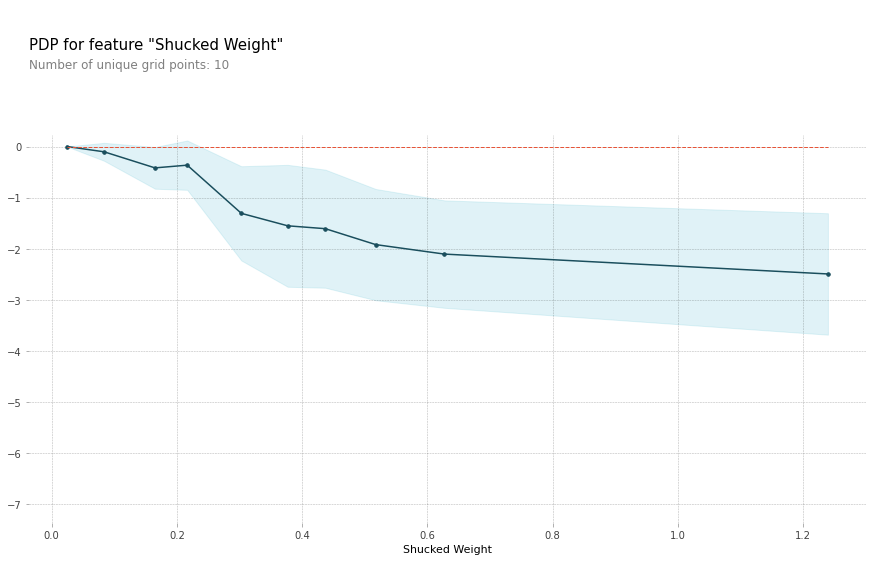

In [63]:
selected_feature = 'Shucked Weight'
pdp_dist = pdp_isolate(
    model=model,
    dataset=x_val,
    model_features=x_val.columns,
    feature=selected_feature
)
pdp.pdp_plot(pdp_dist, selected_feature);

#제출

In [ ]:
#제출
sample_submission['Target'] = final_pred
sample_submission.to_csv('/content/drive/MyDrive/Colab Notebooks/age_data/submission.csv', index=False)

# 사장된 작업들

In [ ]:
# 데이터 oversampling
from imblearn.over_sampling import SMOTE

train_T=train['Target']
target=[]
for i in range(len(train_T)):
    if train_T.iloc[i] < 10:
        target.append(1)
    elif train_T.iloc[i] < 15:
        target.append(2)
    else:
        target.append(3)
        
train["Range"] = target

RS_X = train.drop('Range',axis = 1)
RS_y = train['Range']

oversampling_instance = SMOTE(k_neighbors = 3)
over_X, over_y = oversampling_instance.fit_resample(RS_X, RS_y)
over_X = pd.DataFrame(over_X, columns = train.drop('Range',axis = 1).columns)

train = train.drop('Range', axis = 1)
train = over_X